# MS2 analysis

Jupyter notebook containing analyses for evaluating impact of MS2 and WPRE on barcode capture in nuclei datasets from Shin & Urbanek. Analyses correspond to !!!!!!! 

This notebook contains analyses related to quantifying and visualizing successful barcode capture with three different nuclear capturing strategies:
1) KASH only
2) KASH+MS2
3) KASH+MS2+WPRE

Input for this analysis requires:

1) Cell barcode list for all cells passing transcriptome QC (nCount, nFeature, and mitochondrial% thresholding) per dataset
2) Rabies barcode count matrices with cell barcodes for each dataset
3) Flat.txt files normally input into UMI_tools, which will allow you to calculate barcode reads per library

Output for this analysis includes:

1) Plot showing relationships between barcode UMIs and reads per cell
2) Bar plot showing the fraction of each library with a certain number of barcode UMIs

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: !!!!!!

This code was last amended by Maddie Urbanek on !!!!!

## Notebook set-up

In [2]:
#Load in modules:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from itertools import product
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

In [3]:
#Set working directory to point to barcode diversity libraries
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/fastqs/slice_experiments/ms2_comparison/')

## Import datasets

Import filtered cell barcode lists generated in transcriptome_qc_doublet_filtering.rmd

In [23]:
no_txn=pd.read_table('../../../transcriptome/cellbarcode_lists/no_ms2.csv',delimiter=',')
ms2_txn=pd.read_table('../../../transcriptome/cellbarcode_lists/ms2.csv',delimiter=',')
wpre_txn=pd.read_table('../../../transcriptome/cellbarcode_lists/ms2_wpre.csv',delimiter=',')

Import rabies barcode count matrices

In [24]:
no_bcs=pd.read_table('./no_ms2/bc/completecounts.tsv',delimiter='\t')
ms2_bcs=pd.read_table('./ms2/bc/completecounts.tsv',delimiter='\t')
wpre_bcs=pd.read_table('./ms2_wpre/bc/completecounts.tsv',delimiter='\t')

Import flat.txt files for each library

In [28]:
no_flat=pd.read_table('./no_ms2/bc/flat.txt',delimiter='\t',header=None)
ms2_flat=pd.read_table('./ms2/bc/flat.txt',delimiter='\t',header=None)
wpre_flat=pd.read_table('./ms2_wpre/bc/flat.txt',delimiter='\t',header=None)

### Filter barcode data down to real cells

Barcode UMI count files:

In [25]:
#MS2
ms2_bcs['CBC'] = ms2_bcs['CBC'].str.replace('b', '', regex=True)
ms2_bcs['CBC'] = ms2_bcs['CBC'].str.replace('\'', '', regex=True)
ms2_bcs['CBC'] = 'ms2_' + ms2_bcs['CBC'].astype(str)
ms2_bcs=ms2_bcs.sort_values('CBC')
ms2=ms2_bcs.loc[ms2_bcs['CBC'].isin(ms2_txn.x)]
ms2

#No MS2
no_bcs['CBC'] = no_bcs['CBC'].str.replace('b', '', regex=True)
no_bcs['CBC'] = no_bcs['CBC'].str.replace('\'', '', regex=True)
no_bcs['CBC'] = 'no_ms2_' + no_bcs['CBC'].astype(str)
no_bcs=no_bcs.sort_values('CBC')
no_ms2=no_bcs.loc[no_bcs['CBC'].isin(no_txn.x)]
no_ms2

#MS2+WPRE
wpre_bcs['CBC'] = wpre_bcs['CBC'].str.replace('b', '', regex=True)
wpre_bcs['CBC'] = wpre_bcs['CBC'].str.replace('\'', '', regex=True)
wpre_bcs['CBC'] = 'wpre_' + wpre_bcs['CBC'].astype(str)
wpre_bcs=wpre_bcs.sort_values('CBC')
wpre=wpre_bcs.loc[wpre_bcs['CBC'].isin(wpre_txn.x)]
wpre

,CBC,barcode,UMI_Count
67258,wpre_AAAAAAAAATGGAAGA,barcode,8
4222,wpre_AAAAAAAGCAGCCATG,barcode,42
24610,wpre_AAAAACGTCAGACAAA,barcode,17
17423,wpre_AAAAAGCGAGTTCAGG,barcode,27
22560,wpre_AAAAAGGTATTTAAAA,barcode,31
...,...,...,...
10547,wpre_CCTGAATTAGCTAGAA,barcode,8
2089,wpre_CCTGACCCAAGCATTA,barcode,38
19111,wpre_CCTGAGACCATACCTT,barcode,25
596,wpre_CCTGAGCTATTGAGTG,barcode,34


Flat barcode files:

In [33]:
#Formatting flat files
#MS2
ms2_flat[['read_id','UMI','CBC']]=ms2_flat[0].str.split('_', expand=True)
ms2_flat['CBC'] = 'ms2_' + ms2_flat['CBC'].astype(str)
ms2_flat=ms2_flat.sort_values('CBC')
ms2_filtered_flat=ms2_flat.loc[ms2_flat['CBC'].isin(ms2_txn.x)]
ms2_filtered_flat

#No MS2
no_flat[['read_id','UMI','CBC']]=no_flat[0].str.split('_', expand=True)
no_flat['CBC'] = 'no_ms2_' + no_flat['CBC'].astype(str)
no_flat=no_flat.sort_values('CBC')
no_filtered_flat=no_flat.loc[no_flat['CBC'].isin(no_txn.x)]
no_filtered_flat

#MS2+WPRE
wpre_flat[['read_id','UMI','CBC']]=wpre_flat[0].str.split('_', expand=True)
wpre_flat['CBC'] = 'wpre_' + wpre_flat['CBC'].astype(str)
wpre_flat=wpre_flat.sort_values('CBC')
wpre_filtered_flat=wpre_flat.loc[wpre_flat['CBC'].isin(wpre_txn.x)]
wpre_filtered_flat

,0,1,read_id,UMI,CBC
494657,VH00874:168:AACKG5GHV:2:1507:44192:34604_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:1507:44192:34604,AAAAAAAAATGGAAGAACACTGATAAAA,wpre_AAAAAAAAATGGAAGA
313517,VH00874:168:AACKG5GHV:1:2505:18591:56186_AAAAA...,barcode,VH00874:168:AACKG5GHV:1:2505:18591:56186,AAAAAAAAATGGAAGAGGGTCCAAATAC,wpre_AAAAAAAAATGGAAGA
398771,VH00874:168:AACKG5GHV:2:1203:37356:39734_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:1203:37356:39734,AAAAAAAAATGGAAGAATATCCACAAGC,wpre_AAAAAAAAATGGAAGA
398775,VH00874:168:AACKG5GHV:2:1203:37489:41722_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:1203:37489:41722,AAAAAAAAATGGAAGAATATCCACAAGC,wpre_AAAAAAAAATGGAAGA
459313,VH00874:168:AACKG5GHV:2:1404:44892:41173_AAAAA...,barcode,VH00874:168:AACKG5GHV:2:1404:44892:41173,AAAAAAAAATGGAAGAGCTTATTGGTGC,wpre_AAAAAAAAATGGAAGA
...,...,...,...,...,...
26756,VH00874:168:AACKG5GHV:1:1114:30123:40757_CCTGA...,barcode,VH00874:168:AACKG5GHV:1:1114:30123:40757,CCTGATAGATTGAACGTCATGACAATCG,wpre_CCTGATAGATTGAACG
403879,VH00874:168:AACKG5GHV:2:1205:61688:41874_CCTGA...,barcode,VH00874:168:AACKG5GHV:2:1205:61688:41874,CCTGATAGATTGAACGCGGTTTGGGAAC,wpre_CCTGATAGATTGAACG
357133,VH00874:168:AACKG5GHV:1:2611:62067:12946_CCTGA...,barcode,VH00874:168:AACKG5GHV:1:2611:62067:12946,CCTGATAGATTGAACGCTTTCTAGCGGT,wpre_CCTGATAGATTGAACG
275376,VH00874:168:AACKG5GHV:1:2401:72974:23661_CCTGA...,barcode,VH00874:168:AACKG5GHV:1:2401:72974:23661,CCTGATAGATTGAACGTCATCAACAGGT,wpre_CCTGATAGATTGAACG


Generate read count files

In [34]:
wpre_reads=pd.DataFrame(wpre_filtered_flat['CBC'].value_counts())
no_reads=pd.DataFrame(no_filtered_flat['CBC'].value_counts())
ms2_reads=pd.DataFrame(ms2_filtered_flat['CBC'].value_counts())

### Visualization

##### Barcode UMIs vs. barcode reads per cell by dataset

In [40]:
#Merge reads and UMIs into one table
merged_ms2=pd.merge(ms2, ms2_reads, on="CBC")
merged_no=pd.merge(no_ms2, no_reads, on="CBC")
merged_wpre=pd.merge(wpre, wpre_reads, on="CBC")

,CBC,barcode,UMI_Count,count
0,wpre_AAAAAAAAATGGAAGA,barcode,8,11
1,wpre_AAAAAAAGCAGCCATG,barcode,42,64
2,wpre_AAAAACGTCAGACAAA,barcode,17,44
3,wpre_AAAAAGCGAGTTCAGG,barcode,27,46
4,wpre_AAAAAGGTATTTAAAA,barcode,31,37
...,...,...,...,...
1123,wpre_CCTGAATTAGCTAGAA,barcode,8,9
1124,wpre_CCTGACCCAAGCATTA,barcode,38,61
1125,wpre_CCTGAGACCATACCTT,barcode,25,41
1126,wpre_CCTGAGCTATTGAGTG,barcode,34,79


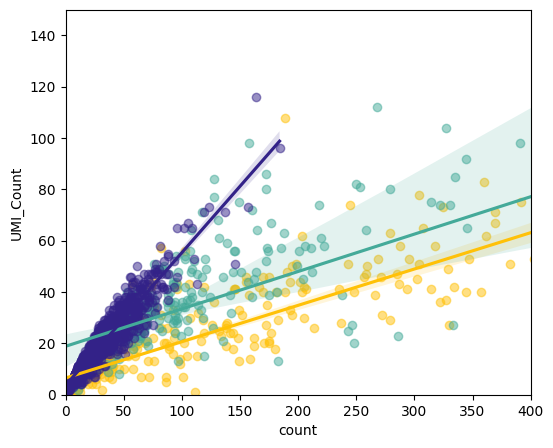

In [46]:
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(data=merged_no, x='count', y='UMI_Count', color = '#FFC107',scatter_kws={'alpha':0.5},label='No MS2')
sns.regplot(data=merged_ms2, x='count', y='UMI_Count', color = '#44AA99',scatter_kws={'alpha':0.5},label='MS2')
sns.regplot(data=merged_wpre, x='count', y='UMI_Count', color = '#332288',scatter_kws={'alpha':0.5},label='WPRE')
ax.set_xlim(0, 400)
ax.set_ylim(0, 150)

ax.figure.savefig("../../../../figs/fig_6/ms2_reads_comparison.pdf")

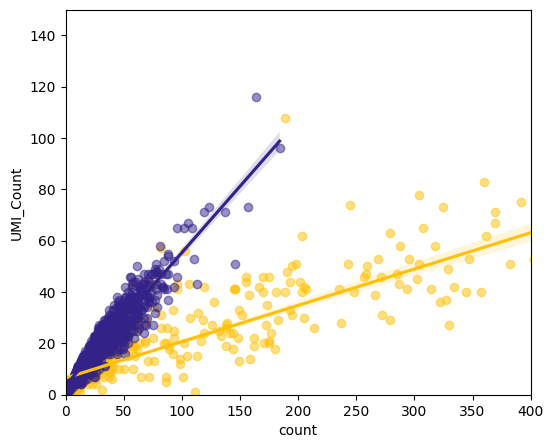

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(data=merged_no, x='count', y='UMI_Count', color = '#FFC107',scatter_kws={'alpha':0.5},label='No MS2')
#sns.regplot(data=merged_ms2, x='count', y='UMI_Count', color = '#44AA99',scatter_kws={'alpha':0.5},label='MS2')
sns.regplot(data=merged_wpre, x='count', y='UMI_Count', color = '#332288',scatter_kws={'alpha':0.5},label='WPRE')
ax.set_xlim(0, 400)
ax.set_ylim(0, 150)

ax.figure.savefig("../../../../figs/fig_6/wpre_v_no_reads_comparison.pdf")

##### Distribution of barcode UMIs per dataset

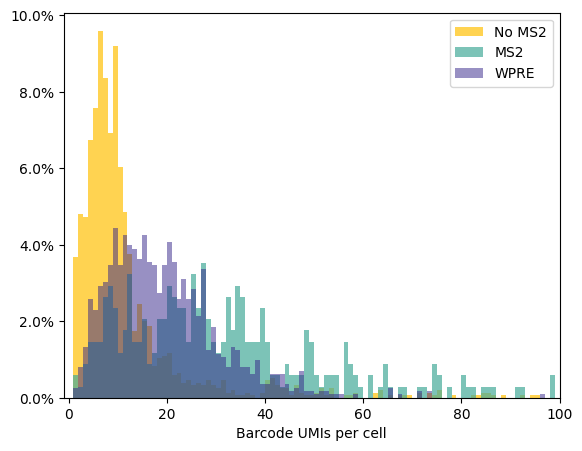

In [56]:
plt.figure().set_figheight(5)
plt.hist(merged_no['UMI_Count'],bins=np.arange(0,merged_no['UMI_Count'].max() + 5, 1),color='#FFC107',alpha=0.7,label='No MS2',weights=np.ones(len(merged_no['UMI_Count'])) / len(merged_no['UMI_Count']))
plt.hist(merged_ms2['UMI_Count'],bins=np.arange(0, merged_ms2['UMI_Count'].max() + 5, 1),color='#44AA99',alpha=0.7,label='MS2',weights=np.ones(len(merged_ms2['UMI_Count'])) / len(merged_ms2['UMI_Count']))
plt.hist(merged_wpre['UMI_Count'],bins=np.arange(0, merged_wpre['UMI_Count'].max() + 5, 1),color='#332288',alpha=0.5,label='WPRE',weights=np.ones(len(merged_wpre['UMI_Count'])) / len(merged_wpre['UMI_Count']))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Barcode UMIs per cell')
#plt.ylabel('Frequency')
plt.xlim([-1, 100])
#plt.ylim([0,100])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../../../../figs/fig_6/ms2_distributions.pdf', bbox_inches='tight', format='pdf')
plt.show()

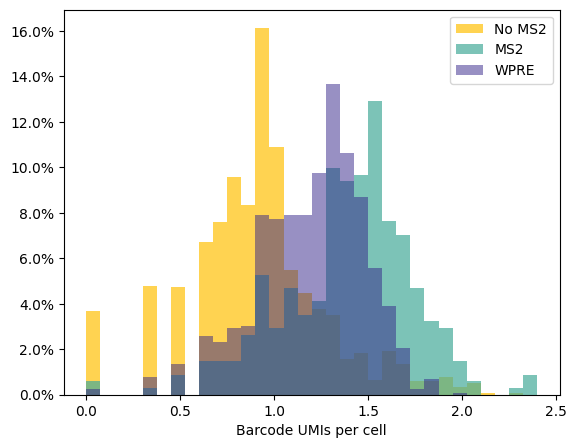

In [65]:
#After UMI thresholding, after assigning to real cells
plt.figure().set_figheight(5)
plt.hist(np.log10(merged_no['UMI_Count']),bins=np.arange(0,np.log10(merged_no['UMI_Count']).max() + .01, .075),color='#FFC107',alpha=0.7,label='No MS2',weights=np.ones(len(merged_no['UMI_Count'])) / len(merged_no['UMI_Count']))
plt.hist(np.log10(merged_ms2['UMI_Count']),bins=np.arange(0, np.log10(merged_ms2['UMI_Count']).max() + .01, .075),color='#44AA99',alpha=0.7,label='MS2',weights=np.ones(len(merged_ms2['UMI_Count'])) / len(merged_ms2['UMI_Count']))
plt.hist(np.log10(merged_wpre['UMI_Count']),bins=np.arange(0, np.log10(merged_wpre['UMI_Count']).max() + .01, .075),color='#332288',alpha=0.5,label='WPRE',weights=np.ones(len(merged_wpre['UMI_Count'])) / len(merged_wpre['UMI_Count']))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel('Barcode UMIs per cell')
#plt.ylabel('Frequency')
#plt.xlim([-1, 100])
#plt.ylim([0,100])
#plt.yscale('log')
plt.legend()
#plt.title('UMIs per Barcode:CBC Combo')
plt.savefig('../../../../figs/fig_6/log_ms2_distributions.pdf', bbox_inches='tight', format='pdf')
plt.show()